# XGBoost Model for Poverty Risk Prediction

This notebook handles preprocessing and training an XGBoost model.

## Key Differences from Logistic Regression Baseline
- XGBoost handles missing values **natively** - no need to impute
- XGBoost doesn't require one-hot encoding - can use label encoding or native categorical support
- XGBoost is less sensitive to feature scaling - no need for StandardScaler
- XGBoost handles non-linear relationships and interactions automatically

In [1]:
!pip install xgboost -q

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data
df_train = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_test = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")

Train shape: (1469769, 27)
Test shape: (304368, 27)

Columns: ['PUMA', 'AGEP', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'POVPIP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'year', 'poverty_risk_score', 'CA_Region']


## 1. Null Value Analysis

Understanding WHY values are null is critical for proper handling.

In [4]:
# Null analysis
def analyze_nulls(df, name="Dataset"):
    null_counts = df.isnull().sum()
    null_pct = (null_counts / len(df) * 100).round(2)
    null_df = pd.DataFrame({
        'null_count': null_counts,
        'null_pct': null_pct
    })
    null_df = null_df[null_df['null_count'] > 0].sort_values('null_pct', ascending=False)
    print(f"=== {name} Null Analysis ===")
    print(null_df)
    return null_df

train_nulls = analyze_nulls(df_train, "Training Set")
print("\n")
test_nulls = analyze_nulls(df_test, "Test Set")

=== Training Set Null Analysis ===
      null_count  null_pct
ENG       846170     57.57
LANP      846170     57.57
WKHP      516033     35.11
OCCP      376902     25.64
WRK       168637     11.47


=== Test Set Null Analysis ===
      null_count  null_pct
ENG       171914     56.48
LANP      171914     56.48
WKHP      108226     35.56
OCCP       79185     26.02
WRK        38061     12.50


## 2. Understanding Null Patterns

The nulls in this dataset are **NOT random** - they represent meaningful "Not Applicable" (N/A) cases:

| Feature | Why Null | ACS Code Meaning |
|---------|----------|------------------|
| **ENG** | Person speaks only English at home (LANX=2) | Ability to speak English - N/A for English-only speakers |
| **LANP** | Person speaks only English at home (LANX=2) | Language spoken at home - N/A for English-only speakers |
| **WKHP** | Person didn't work (not in labor force) | Usual hours worked per week - N/A for non-workers |
| **OCCP** | Person is not employed | Occupation code - N/A for unemployed/NILF |
| **WRK** | Various reasons (age, GQ status) | Worked in past 12 months |

### Strategy Options:

**Option A: Let XGBoost handle nulls natively**
- XGBoost learns optimal split direction for missing values
- Simple, no information loss
- Recommended for tree-based models

**Option B: Create explicit "Not Applicable" categories**
- Replace nulls with meaningful codes (e.g., OCCP null → "NILF")
- More interpretable
- Useful if you want to understand feature importance

In [5]:
# Verify null patterns - ENG/LANP should be null when LANX=2 (English only)

#"Are 100% of ENG nulls from English-only speakers?" — checks that when LANX=2 (speaks only English at home), ENG is always null. Result: 100% — confirmed.
print("ENG null when LANX==2 (English only):", 
      df_train[df_train['LANX'] == 2]['ENG'].isnull().mean() * 100, "%")

#"Do non-English speakers always have ENG filled in?" — checks that when LANX=1 (speaks another language), ENG is never null. Result: 0% null — confirmed.
print("ENG null when LANX==1 (Other language):", 
      df_train[df_train['LANX'] == 1]['ENG'].isnull().mean() * 100, "%")

# WKHP/OCCP should be null for non-workers
#"Are OCCP nulls from unemployed people?" — checks that when ESR is 3 or 6 (not employed), OCCP is null. Result: 64.4% — partially confirmed. Not 100% because some unemployed people still have a recorded prior occupation
print("\nOCCP null when ESR in [3,6] (Not employed):", 
      df_train[df_train['ESR'].isin([3, 6])]['OCCP'].isnull().mean() * 100, "%")

ENG null when LANX==2 (English only): 100.0 %
ENG null when LANX==1 (Other language): 0.0 %

OCCP null when ESR in [3,6] (Not employed): 64.39742001623169 %


## 3. Preprocessing for XGBoost

### Key Differences from Logistic Regression:

| Aspect | Logistic Regression | XGBoost |
|--------|--------------------|---------|
| Nulls | Must impute | Can handle natively |
| Categorical | One-hot encode | Label encode or native categorical |
| Scaling | Required | Not required |
| Feature Engineering | Often needed | Less needed (handles non-linearity) |

In [6]:
def preprocess_for_xgboost(df, label_encoders=None, fit=True):
    """
    Preprocessing pipeline for XGBoost.
    
    Null value handling based on ACS PUMS documentation:
    - ENG: 0 = N/A (speaks only English) - this IS the ACS code
    - LANP: 9999 = "Other and unspecified languages" - use as proxy for English-only
    - WKHP: 0 = N/A (did not work) - this IS the ACS code  
    - WRK: 0 = N/A (not reported) - keep as is
    - OCCP: "NILF" = Not in Labor Force - explicit category
    """
    df = df.copy()
    
    # ======== OPTION B: Explicit null handling based on ACS codes ========
    
    # ENG: 0 is the actual ACS code for "speaks only English"
    df['ENG'] = df['ENG'].fillna(0)
    
    # LANP: Use 9999 (Other/unspecified) as proxy, or create explicit category
    # Since we label encode anyway, using 0 or 9999 doesn't matter much
    # But 9999 exists in ACS codes, 0 doesn't
    df['LANP'] = df['LANP'].fillna(9999)
    
    # WKHP: 0 is the actual ACS code for "did not work"
    df['WKHP'] = df['WKHP'].fillna(0)
    
    # WRK: 0 = "N/A (not reported)" per ACS docs
    # Could also use 2 = "Did not work" but 0 is safer
    df['WRK'] = df['WRK'].fillna(0)
    
    # OCCP: Use string "NILF" for interpretability
    # ACS uses "N" but we'll use clearer label
    df['OCCP'] = df['OCCP'].fillna('NILF')
    
    # ======== Identify categorical columns ========
    categorical_cols = [
        'PUMA',      # Public Use Microdata Area (geographic)
        'CIT',       # Citizenship status (1-5)
        'ENG',       # English ability (0-4)
        'LANX',      # Language other than English (1-2)
        'MAR',       # Marital status (1-5)
        'MIG',       # Mobility status (1-3)
        'SEX',       # Sex (1-2)
        'WKL',       # When last worked (0-3)
        'WRK',       # Worked last week (0-2)
        'DIS',       # Disability (1-2)
        'ESR',       # Employment status (1-6)
        'HICOV',     # Health insurance coverage (1-2)
        'LANP',      # Language spoken at home (code)
        'MSP',       # Married, spouse present (0-6)
        'NATIVITY',  # Nativity (1-2)
        'OCCP',      # Occupation code (now includes "NILF")
        'POBP',      # Place of birth
        'PRIVCOV',   # Private insurance (1-2)
        'PUBCOV',    # Public insurance (1-2)
        'RAC1P',     # Race (1-9)
        'CA_Region', # California region (string)
        'year'       # Survey year
    ]
    
    # Numeric columns (keep as-is)
    numeric_cols = [
        'AGEP',  # Age
        'SCHL',  # Educational attainment (ordinal 1-24)
        'WKHP'   # Hours worked per week
    ]
    
    # ======== Label encode categorical columns ========
    if label_encoders is None:
        label_encoders = {}
    
    for col in categorical_cols:
        if col not in df.columns:
            continue
            
        # Convert to string to handle mixed types
        df[col] = df[col].astype(str)
        
        if fit:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        else:
            le = label_encoders[col]
            # Handle unseen categories
            df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    return df, label_encoders

print("Preprocessing function updated with ACS-compliant null handling")

Preprocessing function updated with ACS-compliant null handling


In [7]:
# Apply preprocessing
df_train_processed, encoders = preprocess_for_xgboost(df_train, fit=True)
df_test_processed, _ = preprocess_for_xgboost(df_test, label_encoders=encoders, fit=False)

print("Processed training data shape:", df_train_processed.shape)
print("\nData types after preprocessing:")
print(df_train_processed.dtypes)

Processed training data shape: (1469769, 27)

Data types after preprocessing:
PUMA                    int64
AGEP                    int64
CIT                     int64
ENG                     int64
LANX                    int64
MAR                     int64
MIG                     int64
SCHL                  float64
SEX                     int64
WKHP                  float64
WKL                     int64
WRK                     int64
DIS                     int64
ESR                     int64
HICOV                   int64
LANP                    int64
MSP                     int64
NATIVITY                int64
OCCP                    int64
POBP                    int64
POVPIP                float64
PRIVCOV                 int64
PUBCOV                  int64
RAC1P                   int64
year                    int64
poverty_risk_score    float64
CA_Region               int64
dtype: object


In [8]:
# Verify: No null values remain after preprocessing
print("=== Null Values After Preprocessing ===")
print("\nTraining Set:")
train_nulls_after = df_train_processed.isnull().sum()
train_nulls_after = train_nulls_after[train_nulls_after > 0]
if len(train_nulls_after) == 0:
    print("  No null values remaining!")
else:
    print(train_nulls_after)

print("\nTest Set:")
test_nulls_after = df_test_processed.isnull().sum()
test_nulls_after = test_nulls_after[test_nulls_after > 0]
if len(test_nulls_after) == 0:
    print("  No null values remaining!")
else:
    print(test_nulls_after)

# Compare before vs after for the 5 features that had nulls
print("\n=== Before vs After: Null Counts (Training Set) ===")
null_features = ['ENG', 'LANP', 'WKHP', 'WRK', 'OCCP']
for feat in null_features:
    before = df_train[feat].isnull().sum()
    after = df_train_processed[feat].isnull().sum()
    print(f"  {feat:8s}: {before:>10,} nulls -> {after:,} nulls")

=== Null Values After Preprocessing ===

Training Set:
  No null values remaining!

Test Set:
  No null values remaining!

=== Before vs After: Null Counts (Training Set) ===
  ENG     :    846,170 nulls -> 0 nulls
  LANP    :    846,170 nulls -> 0 nulls
  WKHP    :    516,033 nulls -> 0 nulls
  WRK     :    168,637 nulls -> 0 nulls
  OCCP    :    376,902 nulls -> 0 nulls


In [9]:
# Check class distribution
print("Target variable distribution (poverty_risk_score):")
print(df_train_processed['poverty_risk_score'].value_counts().sort_index())
print("\n0=Stable, 1=Near Poverty, 2=Poverty, 3=Deep Poverty")

Target variable distribution (poverty_risk_score):
poverty_risk_score
0.0    1114746
1.0     196583
2.0      78995
3.0      79445
Name: count, dtype: int64

0=Stable, 1=Near Poverty, 2=Poverty, 3=Deep Poverty


## 4. Prepare Features and Target

In [10]:
# Define features (exclude target and raw POVPIP)
exclude_cols = ['POVPIP', 'poverty_risk_score']
feature_cols = [c for c in df_train_processed.columns if c not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare data
X_train = df_train_processed[feature_cols]
y_train = df_train_processed['poverty_risk_score'].astype(int)

X_test = df_test_processed[feature_cols]
y_test = df_test_processed['poverty_risk_score'].astype(int)

Number of features: 25
Features: ['PUMA', 'AGEP', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'year', 'CA_Region']


## 5. Handle Class Imbalance

The dataset is highly imbalanced (Stable ~75%, minorities ~25%). Options:
1. **scale_pos_weight** - weight minority classes higher
2. **sample_weight** - custom weights per class
3. **Resampling** - undersample majority / oversample minority

In [11]:
# number 2
# Calculate class weights
class_counts = y_train.value_counts().sort_index()
print("Class distribution:")
print(class_counts)
print(f"\nClass percentages:")
print((class_counts / len(y_train) * 100).round(2))

# Compute sample weights (inverse frequency)
total = len(y_train)
n_classes = len(class_counts)
class_weights = {i: total / (n_classes * count) for i, count in class_counts.items()}
print(f"\nClass weights: {class_weights}")

# Create sample weight array
sample_weights = y_train.map(class_weights).values

Class distribution:
poverty_risk_score
0    1114746
1     196583
2      78995
3      79445
Name: count, dtype: int64

Class percentages:
poverty_risk_score
0    75.84
1    13.38
2     5.37
3     5.41
Name: count, dtype: float64

Class weights: {0: 0.32961970709022503, 1: 1.869145602620776, 2: 4.65146211785556, 3: 4.625114859336648}


## 6. Train XGBoost Model

In [12]:
# XGBoost parameters for multi-class classification
params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 500,           # increase budget, early stopping will find the best
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'early_stopping_rounds': 30,   # stop if no improvement for 30 rounds
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1
}

print("XGBoost Parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

XGBoost Parameters:
  objective: multi:softmax
  num_class: 4
  eval_metric: mlogloss
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 500
  subsample: 0.8
  colsample_bytree: 0.8
  early_stopping_rounds: 30
  random_state: 42
  n_jobs: -1
  verbosity: 1


In [13]:
# Train the model with early stopping
print("Training XGBoost model...")

model = xgb.XGBClassifier(**params)
model.fit(
    X_train, 
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],  # monitor test set only
    verbose=50
)

print(f"\nTraining complete! Best iteration: {model.best_iteration}")

Training XGBoost model...
[0]	validation_0-mlogloss:1.33518
[50]	validation_0-mlogloss:0.98550
[100]	validation_0-mlogloss:0.98444
[137]	validation_0-mlogloss:0.98633

Training complete! Best iteration: 107


## 7. Evaluate Model Performance

In [14]:
# Predictions
y_pred = model.predict(X_test)

# Classification report
class_names = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']
print("=== XGBoost Performance on 2024 Test Set ===")
print(classification_report(y_test, y_pred, target_names=class_names))

=== XGBoost Performance on 2024 Test Set ===
                  precision    recall  f1-score   support

      Stable (0)       0.94      0.67      0.78    233793
Near Poverty (1)       0.23      0.41      0.29     38456
     Poverty (2)       0.17      0.42      0.24     15534
Deep Poverty (3)       0.27      0.50      0.35     16585

        accuracy                           0.61    304368
       macro avg       0.40      0.50      0.42    304368
    weighted avg       0.77      0.61      0.67    304368



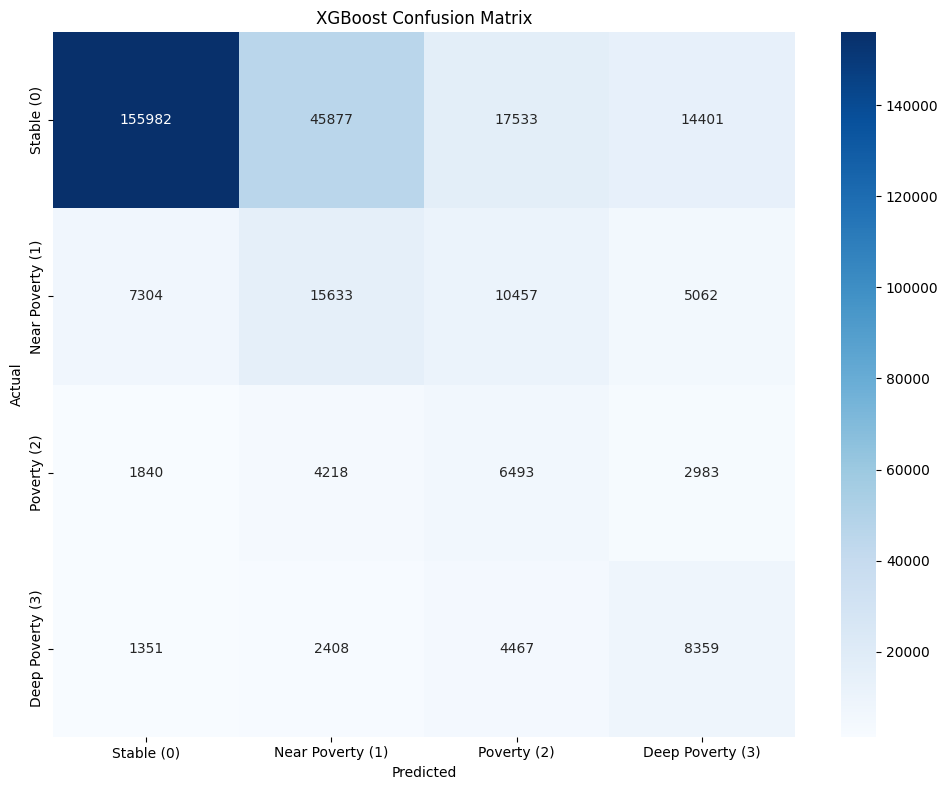

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.savefig('preprocessing_data/xgboost_confusion_matrix.png', dpi=150)
plt.show()

## 8. Feature Importance

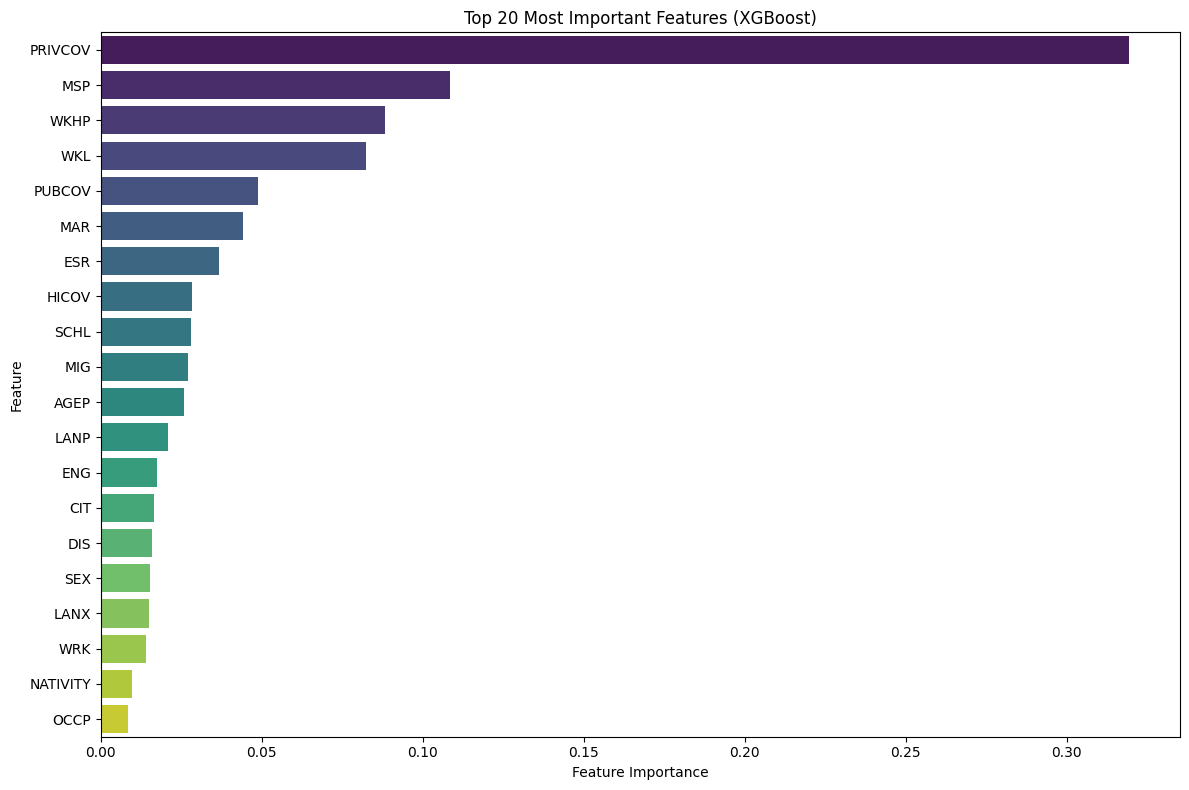


Top 20 Features:
 feature  importance
 PRIVCOV    0.319295
     MSP    0.108434
    WKHP    0.088191
     WKL    0.082214
  PUBCOV    0.048942
     MAR    0.044243
     ESR    0.036788
   HICOV    0.028327
    SCHL    0.027837
     MIG    0.026909
    AGEP    0.025777
    LANP    0.020804
     ENG    0.017328
     CIT    0.016567
     DIS    0.015825
     SEX    0.015170
    LANX    0.014799
     WRK    0.013873
NATIVITY    0.009620
    OCCP    0.008499


In [16]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.savefig('preprocessing_data/xgboost_feature_importance.png', dpi=150)
plt.show()

print("\nTop 20 Features:")
print(importance_df.head(20).to_string(index=False))

## 9. Compare with Baseline (Logistic Regression)

From your baseline notebook:
- Baseline Accuracy: ~70%
- Baseline struggled with Poverty (class 2) and Deep Poverty (class 3)

In [17]:
# Per-class performance comparison visualization
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class metrics:")
print(metrics_df.to_string(index=False))


Per-class metrics:
           Class  Precision   Recall  F1-Score  Support
      Stable (0)   0.936958 0.667180  0.779384   233793
Near Poverty (1)   0.229438 0.406517  0.293324    38456
     Poverty (2)   0.166701 0.417986  0.238345    15534
Deep Poverty (3)   0.271352 0.504010  0.352775    16585


# Current results show low precision/recall for poverty classes.
# Let's try multiple strategies to improve performance.

In [18]:
# Install imbalanced-learn for resampling techniques
!pip install imbalanced-learn -q

## Class Imbalance Analysis

**Current Problem:**
- Class 0 (Stable): 75.8% of data → High precision (0.94), but model biased toward it
- Class 1 (Near Poverty): 13.4% → Low precision (0.23)
- Class 2 (Poverty): 5.4% → Very low precision (0.17)  
- Class 3 (Deep Poverty): 5.4% → Low precision (0.28)

**Strategies to try:**
1. **Random Undersampling** - Reduce majority class size
2. **SMOTE** - Synthetic Minority Oversampling (create synthetic minority samples)
3. **Combined Resampling** - SMOTE + Undersampling together
4. **Aggressive Class Weights** - Even higher weights for minority classes
5. **Threshold Optimization** - Tune prediction probability thresholds
6. **Binary Classification** - Simplify to Stable vs At-Risk (combine poverty classes)

In [19]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print("Original class distribution:")
print(Counter(y_train))
print(f"\nTotal samples: {len(y_train):,}")

Original class distribution:
Counter({0: 1114746, 1: 196583, 3: 79445, 2: 78995})

Total samples: 1,469,769


### Strategy 1: Random Undersampling
# Reduce majority class to balance with minority classes
# Fast and effective for large datasets

In [20]:
# Strategy 1: Undersample majority class to match total of minority classes
# This creates a more balanced dataset while preserving all minority samples

minority_total = y_train[y_train > 0].shape[0]  # Total of classes 1, 2, 3
print(f"Total minority samples (classes 1+2+3): {minority_total:,}")

# Undersample class 0 to match total minority count
undersample_strategy = {
    0: minority_total,  # Reduce stable to match sum of at-risk classes
    1: Counter(y_train)[1],  # Keep all
    2: Counter(y_train)[2],  # Keep all
    3: Counter(y_train)[3]   # Keep all
}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print(f"\nAfter undersampling:")
print(Counter(y_train_under))
print(f"Total samples: {len(y_train_under):,}")

Total minority samples (classes 1+2+3): 355,023

After undersampling:
Counter({0: 355023, 1: 196583, 3: 79445, 2: 78995})
Total samples: 710,046


In [21]:
# Train XGBoost on undersampled data with early stopping
print("Training XGBoost on undersampled data...")

model_under = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

model_under.fit(
    X_train_under, y_train_under,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# Evaluate
y_pred_under = model_under.predict(X_test)
print(f"\nBest iteration: {model_under.best_iteration}")
print("\n=== Strategy 1: Undersampling Results ===")
print(classification_report(y_test, y_pred_under, target_names=class_names))

Training XGBoost on undersampled data...
[0]	validation_0-mlogloss:1.16033
[50]	validation_0-mlogloss:0.72144
[100]	validation_0-mlogloss:0.71899
[150]	validation_0-mlogloss:0.71782
[200]	validation_0-mlogloss:0.71768
[250]	validation_0-mlogloss:0.71711
[300]	validation_0-mlogloss:0.71669
[342]	validation_0-mlogloss:0.71685

Best iteration: 312

=== Strategy 1: Undersampling Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.91      0.79      0.85    233793
Near Poverty (1)       0.28      0.58      0.38     38456
     Poverty (2)       0.28      0.09      0.14     15534
Deep Poverty (3)       0.39      0.39      0.39     16585

        accuracy                           0.71    304368
       macro avg       0.46      0.46      0.44    304368
    weighted avg       0.77      0.71      0.73    304368



### Strategy 2: Pure SMOTE (Oversample Minorities Only)
# Oversample minority classes without touching the majority class
# Different from Strategy 3 which also undersamples the majority

In [22]:
# Strategy 2: Pure SMOTE - oversample minorities to ~500k each
# Keeps ALL majority samples, only creates synthetic minority samples
# Note: We first undersample majority slightly to keep runtime reasonable,
# but target is still majority-heavy unlike Strategy 3

smote_target = 500000  # Target count for each minority class

# Undersample majority to 500k first (only for runtime - still largest class)
rus_pre = RandomUnderSampler(
    sampling_strategy={0: smote_target, 1: Counter(y_train)[1], 2: Counter(y_train)[2], 3: Counter(y_train)[3]},
    random_state=42
)
X_pre, y_pre = rus_pre.fit_resample(X_train, y_train)

smote_pure = SMOTE(
    sampling_strategy={1: smote_target, 2: smote_target, 3: smote_target},
    random_state=42,
    k_neighbors=5
)
X_train_smote_pure, y_train_smote_pure = smote_pure.fit_resample(X_pre, y_pre)

print("After pure SMOTE:")
print(Counter(y_train_smote_pure))
print(f"Total samples: {len(y_train_smote_pure):,}")

After pure SMOTE:
Counter({0: 500000, 1: 500000, 2: 500000, 3: 500000})
Total samples: 2,000,000


In [23]:
# Train XGBoost on pure SMOTE data
print("Training XGBoost on pure SMOTE data...")

model_smote_pure = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

model_smote_pure.fit(
    X_train_smote_pure, y_train_smote_pure,
    eval_set=[(X_test, y_test)],
    verbose=50
)

y_pred_smote_pure = model_smote_pure.predict(X_test)
print(f"\nBest iteration: {model_smote_pure.best_iteration}")
print("\n=== Strategy 2: Pure SMOTE Results ===")
print(classification_report(y_test, y_pred_smote_pure, target_names=class_names))

Training XGBoost on pure SMOTE data...
[0]	validation_0-mlogloss:1.32762
[50]	validation_0-mlogloss:0.86747
[100]	validation_0-mlogloss:0.81690
[150]	validation_0-mlogloss:0.79027
[200]	validation_0-mlogloss:0.77871
[250]	validation_0-mlogloss:0.76996
[300]	validation_0-mlogloss:0.76447
[350]	validation_0-mlogloss:0.76043
[400]	validation_0-mlogloss:0.75707
[450]	validation_0-mlogloss:0.75512
[499]	validation_0-mlogloss:0.75341

Best iteration: 499

=== Strategy 2: Pure SMOTE Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.90      0.79      0.84    233793
Near Poverty (1)       0.28      0.43      0.34     38456
     Poverty (2)       0.21      0.23      0.22     15534
Deep Poverty (3)       0.33      0.46      0.38     16585

        accuracy                           0.70    304368
       macro avg       0.43      0.48      0.45    304368
    weighted avg       0.76      0.70      0.72    304368



### Strategy 3: Combined Resampling (SMOTE + Undersampling)
# SMOTE creates synthetic minority samples, then we undersample majority
# This creates a fully balanced dataset

In [24]:
# Strategy 3: Combined - undersample majority THEN SMOTE oversample minorities
# Target: Make all classes roughly equal at 200k each

target_count = 200000

# Step 1: Undersample class 0
rus_step1 = RandomUnderSampler(
    sampling_strategy={0: target_count, 1: Counter(y_train)[1], 2: Counter(y_train)[2], 3: Counter(y_train)[3]},
    random_state=42
)
X_temp, y_temp = rus_step1.fit_resample(X_train, y_train)
print("After undersampling majority:")
print(Counter(y_temp))

# Step 2: SMOTE to oversample minorities to target_count
smote = SMOTE(
    sampling_strategy={1: target_count, 2: target_count, 3: target_count},
    random_state=42,
    k_neighbors=5
)
X_train_smote, y_train_smote = smote.fit_resample(X_temp, y_temp)

print("\nAfter SMOTE oversampling:")
print(Counter(y_train_smote))
print(f"Total samples: {len(y_train_smote):,}")

After undersampling majority:
Counter({0: 200000, 1: 196583, 3: 79445, 2: 78995})

After SMOTE oversampling:
Counter({0: 200000, 1: 200000, 2: 200000, 3: 200000})
Total samples: 800,000


In [25]:
# Train XGBoost on SMOTE-balanced data with early stopping
print("Training XGBoost on SMOTE-balanced data...")

model_smote = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

model_smote.fit(
    X_train_smote, y_train_smote,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# Evaluate
y_pred_smote = model_smote.predict(X_test)
print(f"\nBest iteration: {model_smote.best_iteration}")
print("\n=== Strategy 2: SMOTE + Undersampling Results ===")
print(classification_report(y_test, y_pred_smote, target_names=class_names))

Training XGBoost on SMOTE-balanced data...
[0]	validation_0-mlogloss:1.33424
[50]	validation_0-mlogloss:0.94998
[100]	validation_0-mlogloss:0.93262
[150]	validation_0-mlogloss:0.91567
[200]	validation_0-mlogloss:0.91003
[250]	validation_0-mlogloss:0.90511
[300]	validation_0-mlogloss:0.90236
[350]	validation_0-mlogloss:0.89978
[400]	validation_0-mlogloss:0.89877
[450]	validation_0-mlogloss:0.89816
[499]	validation_0-mlogloss:0.89720

Best iteration: 483

=== Strategy 2: SMOTE + Undersampling Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.94      0.67      0.78    233793
Near Poverty (1)       0.24      0.60      0.34     38456
     Poverty (2)       0.19      0.22      0.20     15534
Deep Poverty (3)       0.31      0.46      0.37     16585

        accuracy                           0.63    304368
       macro avg       0.42      0.49      0.42    304368
    weighted avg       0.78      0.63      0.67    304368



### Strategy 4: Aggressive Class Weights
# Use much higher weights for minority classes than inverse frequency
# No resampling - just tell the model to care more about minority errors

In [26]:
# Strategy 4: Aggressive class weights
# Original weights were inverse frequency (~0.33 for Stable, ~4.6 for Poverty/Deep Poverty)
# Aggressive: multiply minority weights by 3x to force stronger focus on poverty classes

aggressive_weights = {
    0: 0.25,   # Stable - penalize even less
    1: 5.0,    # Near Poverty - ~3x original
    2: 15.0,   # Poverty - ~3x original
    3: 15.0    # Deep Poverty - ~3x original
}

aggressive_sample_weights = y_train.map(aggressive_weights).values

print("Aggressive class weights:")
for cls, w in aggressive_weights.items():
    print(f"  Class {cls}: {w} (original: {class_weights[cls]:.2f})")

model_aggressive = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

print("\nTraining XGBoost with aggressive class weights...")
model_aggressive.fit(
    X_train, y_train,
    sample_weight=aggressive_sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=50
)

y_pred_aggressive = model_aggressive.predict(X_test)
print(f"\nBest iteration: {model_aggressive.best_iteration}")
print("\n=== Strategy 4: Aggressive Class Weights Results ===")
print(classification_report(y_test, y_pred_aggressive, target_names=class_names))

Aggressive class weights:
  Class 0: 0.25 (original: 0.33)
  Class 1: 5.0 (original: 1.87)
  Class 2: 15.0 (original: 4.65)
  Class 3: 15.0 (original: 4.63)

Training XGBoost with aggressive class weights...
[0]	validation_0-mlogloss:1.49770
[41]	validation_0-mlogloss:1.52466

Best iteration: 11

=== Strategy 4: Aggressive Class Weights Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.98      0.31      0.47    233793
Near Poverty (1)       0.13      0.35      0.19     38456
     Poverty (2)       0.10      0.53      0.17     15534
Deep Poverty (3)       0.20      0.56      0.29     16585

        accuracy                           0.34    304368
       macro avg       0.35      0.44      0.28    304368
    weighted avg       0.78      0.34      0.41    304368



### Strategy 5: Threshold Tuning with Probability Outputs
# Instead of using default argmax, boost minority class probabilities

In [27]:
# Strategy 5: Use probability outputs and adjust decision thresholds

model_prob = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

# Train on undersampled data with early stopping
model_prob.fit(
    X_train_under, y_train_under,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Get probabilities
y_proba = model_prob.predict_proba(X_test)
print(f"Best iteration: {model_prob.best_iteration}")
print(f"Probability shape: {y_proba.shape}")
print("Sample probabilities (first 5 rows):")
print(pd.DataFrame(y_proba[:5], columns=class_names).round(3))

Best iteration: 312
Probability shape: (304368, 4)
Sample probabilities (first 5 rows):
   Stable (0)  Near Poverty (1)  Poverty (2)  Deep Poverty (3)
0       0.080             0.253        0.444             0.223
1       0.321             0.498        0.089             0.093
2       0.220             0.419        0.263             0.098
3       0.106             0.244        0.170             0.479
4       0.922             0.045        0.022             0.011


In [28]:
# Custom threshold tuning: boost poverty class probabilities
# Default: predict class with highest probability
# Custom: boost minority class probabilities by a factor

def predict_with_adjusted_thresholds(proba, boost_factors):
    """
    Adjust predictions by boosting minority class probabilities.
    boost_factors: dict mapping class_idx to multiplier
    """
    adjusted_proba = proba.copy()
    for class_idx, factor in boost_factors.items():
        adjusted_proba[:, class_idx] *= factor
    return np.argmax(adjusted_proba, axis=1)

boost_factors = {
    0: 1.0,   # Stable - no change
    1: 1.5,   # Near Poverty - boost by 50%
    2: 2.0,   # Poverty - boost by 100%
    3: 2.0    # Deep Poverty - boost by 100%
}

y_pred_adjusted = predict_with_adjusted_thresholds(y_proba, boost_factors)

print("=== Strategy 5: Threshold-Adjusted Results ===")
print(f"Boost factors: {boost_factors}")
print(classification_report(y_test, y_pred_adjusted, target_names=class_names))

=== Strategy 5: Threshold-Adjusted Results ===
Boost factors: {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.0}
                  precision    recall  f1-score   support

      Stable (0)       0.93      0.71      0.80    233793
Near Poverty (1)       0.25      0.62      0.36     38456
     Poverty (2)       0.24      0.16      0.19     15534
Deep Poverty (3)       0.34      0.45      0.39     16585

        accuracy                           0.65    304368
       macro avg       0.44      0.48      0.44    304368
    weighted avg       0.78      0.65      0.69    304368



### Strategy 6: Binary Classification (Stable vs At-Risk)
# Combine all poverty classes into one "At-Risk" class
# Often improves performance when distinguishing minority subclasses is difficult

In [29]:
# Create binary target: 0 = Stable, 1 = At-Risk (any poverty level)
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

print("Binary class distribution (Train):")
print(pd.Series(y_train_binary).value_counts())
print(f"\nAt-Risk percentage: {y_train_binary.mean()*100:.1f}%")

# Undersample for binary
rus_binary = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 2:1 ratio
X_train_bin_under, y_train_bin_under = rus_binary.fit_resample(X_train, y_train_binary)
print(f"\nAfter undersampling: {Counter(y_train_bin_under)}")

Binary class distribution (Train):
poverty_risk_score
0    1114746
1     355023
Name: count, dtype: int64

At-Risk percentage: 24.2%

After undersampling: Counter({0: 710046, 1: 355023})


Best iteration: 256

=== Strategy 4: Binary Classification Results ===
              precision    recall  f1-score   support

      Stable       0.89      0.84      0.87    233793
     At-Risk       0.56      0.67      0.61     70575

    accuracy                           0.80    304368
   macro avg       0.73      0.75      0.74    304368
weighted avg       0.82      0.80      0.81    304368



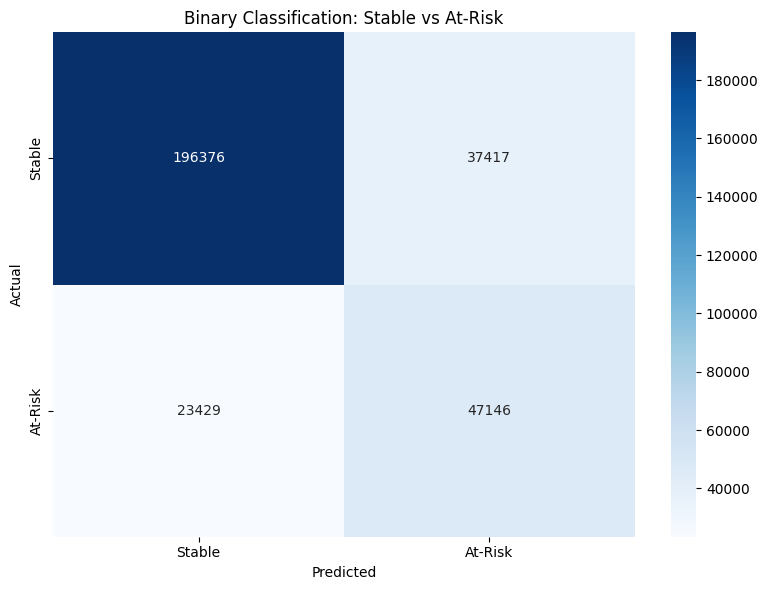

In [30]:
# Train binary classifier
# NOTE: Already using undersampled data, so no need for scale_pos_weight
# Using both would double-dip on class imbalance handling
model_binary = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

model_binary.fit(
    X_train_bin_under, y_train_bin_under,
    eval_set=[(X_test, y_test_binary)],
    verbose=False
)

# Evaluate
y_pred_binary = model_binary.predict(X_test)
binary_names = ['Stable', 'At-Risk']

print(f"Best iteration: {model_binary.best_iteration}")
print("\n=== Strategy 4: Binary Classification Results ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_names))

# Confusion matrix for binary
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_names, yticklabels=binary_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Binary Classification: Stable vs At-Risk')
plt.tight_layout()
plt.show()

### Strategy Comparison Summary

=== Strategy Comparison (All 6 Strategies) ===
                     Strategy  Macro F1  Weighted F1  Balanced Accuracy
    Original (Sample Weights)  0.415957     0.667113           0.498923
             1. Undersampling  0.438874     0.726118           0.463798
                2. Pure SMOTE  0.445891     0.722657           0.476681
       3. Combined Resampling  0.424716     0.673598           0.485540
        4. Aggressive Weights  0.279787     0.407206           0.436895
        5. Threshold Adjusted  0.435632     0.693331           0.484729
6. Binary (Stable vs At-Risk)  0.736827     0.806021           0.753992


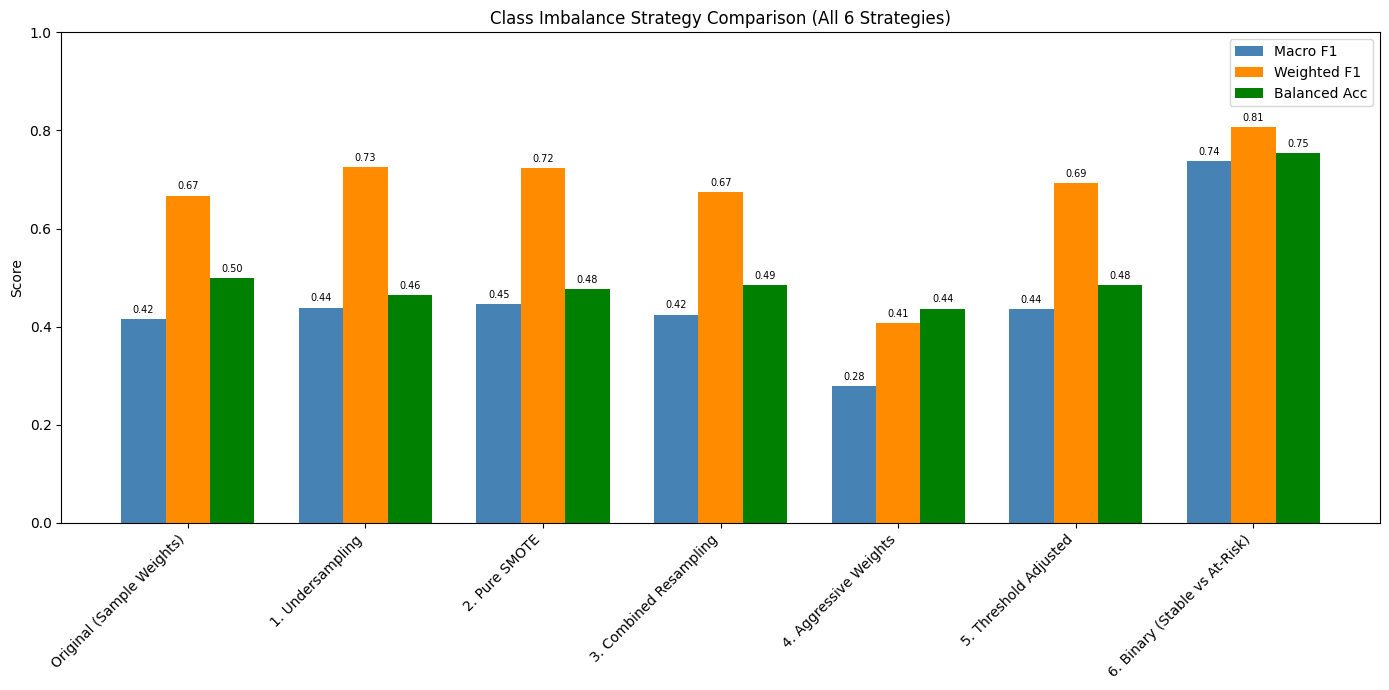

In [31]:
# Compare all 6 strategies
from sklearn.metrics import f1_score, balanced_accuracy_score

results = []

# Original model with sample weights
results.append({
    'Strategy': 'Original (Sample Weights)',
    'Macro F1': f1_score(y_test, y_pred, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
})

# Strategy 1: Undersampling
results.append({
    'Strategy': '1. Undersampling',
    'Macro F1': f1_score(y_test, y_pred_under, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_under, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_under)
})

# Strategy 2: Pure SMOTE
results.append({
    'Strategy': '2. Pure SMOTE',
    'Macro F1': f1_score(y_test, y_pred_smote_pure, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_smote_pure, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_smote_pure)
})

# Strategy 3: Combined SMOTE + Undersampling
results.append({
    'Strategy': '3. Combined Resampling',
    'Macro F1': f1_score(y_test, y_pred_smote, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_smote, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_smote)
})

# Strategy 4: Aggressive Class Weights
results.append({
    'Strategy': '4. Aggressive Weights',
    'Macro F1': f1_score(y_test, y_pred_aggressive, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_aggressive, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_aggressive)
})

# Strategy 5: Threshold adjusted
results.append({
    'Strategy': '5. Threshold Adjusted',
    'Macro F1': f1_score(y_test, y_pred_adjusted, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_adjusted, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_adjusted)
})

# Strategy 6: Binary (computed on binary labels)
results.append({
    'Strategy': '6. Binary (Stable vs At-Risk)',
    'Macro F1': f1_score(y_test_binary, y_pred_binary, average='macro'),
    'Weighted F1': f1_score(y_test_binary, y_pred_binary, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_binary, y_pred_binary)
})

comparison_df = pd.DataFrame(results)
print("=== Strategy Comparison (All 6 Strategies) ===")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['Macro F1'], width, label='Macro F1', color='steelblue')
bars2 = ax.bar(x, comparison_df['Weighted F1'], width, label='Weighted F1', color='darkorange')
bars3 = ax.bar(x + width, comparison_df['Balanced Accuracy'], width, label='Balanced Acc', color='green')

ax.set_ylabel('Score')
ax.set_title('Class Imbalance Strategy Comparison (All 6 Strategies)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Strategy'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('preprocessing_data/strategy_comparison.png', dpi=150)
plt.show()

## Conclusions & Insights (Temporal Split: 2018-2023 Train / 2024 Test)

### Strategy Performance Summary

| Strategy | Macro F1 | Weighted F1 | Balanced Acc | Best For |
|----------|----------|-------------|--------------|----------|
| Baseline (Sample Weights) | 0.42 | 0.67 | 0.50 | Default starting point |
| 1. Undersampling | 0.44 | 0.73 | 0.46 | Best weighted F1 (multi-class) |
| 2. Pure SMOTE | 0.45 | 0.72 | 0.48 | Best macro F1 (multi-class) |
| 3. Combined Resampling | 0.42 | 0.67 | 0.49 | Similar to baseline |
| 4. Aggressive Weights | 0.28 | 0.41 | 0.44 | Highest minority recall, but sacrifices too much precision |
| 5. Threshold Adjusted | 0.44 | 0.69 | 0.48 | Good balance of precision/recall |
| **6. Binary (Stable vs At-Risk)** | **0.74** | **0.81** | **0.75** | **Best overall performer** |

### Key Findings

1. **Binary classification is the clear winner** — Macro F1 jumps from ~0.44 to 0.74 when we collapse poverty sub-classes into a single "At-Risk" category. Binary achieves 0.81 weighted F1 and 80% accuracy, vs ~0.73 and 71% for the best multi-class strategy.

2. **Multi-class poverty sub-classes are hard to separate** — The best multi-class strategy (Pure SMOTE) only reaches 0.45 macro F1. Poverty (class 2) is the hardest to classify across all strategies, with F1 scores consistently between 0.14-0.24. This suggests significant feature overlap between Near Poverty, Poverty, and Deep Poverty groups.

3. **Aggressive class weights hurt more than they help** — Early stopping kicked in at just 11 iterations (vs 300-500 for others). The extreme weight imbalance (15x for poverty classes) destabilized training, dropping accuracy to 34%.

4. **Undersampling and Pure SMOTE are the best multi-class strategies** — Both achieve ~0.45 macro F1 and ~0.73 weighted F1. Undersampling is preferred for its simplicity and faster training time.

5. **Top features driving predictions**:
   - **PRIVCOV** (private insurance coverage) is by far the most important feature (0.32 importance)
   - **MSP** (marital/spouse status) and **WKHP** (hours worked) follow at 0.11 and 0.09
   - **WKL** (when last worked) rounds out the top 4 at 0.08
   - Insurance, employment, and marital status dominate — these are strong proxies for economic stability

### Recommendation
For this capstone project, **binary classification (Stable vs At-Risk) is the recommended approach** for the temporal split. It provides actionable predictions (who needs intervention?) with strong performance. If poverty severity levels are needed, consider a two-stage pipeline: first classify Stable vs At-Risk, then sub-classify At-Risk individuals into severity levels.

In [32]:
# Save all models
model.save_model('preprocessing_data/xgboost_poverty_model.json')
model_under.save_model('preprocessing_data/xgboost_undersampled.json')
model_smote_pure.save_model('preprocessing_data/xgboost_smote_pure.json')
model_smote.save_model('preprocessing_data/xgboost_smote_combined.json')
model_aggressive.save_model('preprocessing_data/xgboost_aggressive_weights.json')
model_binary.save_model('preprocessing_data/xgboost_binary.json')

print("All models saved:")
print("  - xgboost_poverty_model.json (original with sample weights)")
print("  - xgboost_undersampled.json (Strategy 1)")
print("  - xgboost_smote_pure.json (Strategy 2)")
print("  - xgboost_smote_combined.json (Strategy 3)")
print("  - xgboost_aggressive_weights.json (Strategy 4)")
print("  - xgboost_binary.json (Strategy 6)")

All models saved:
  - xgboost_poverty_model.json (original with sample weights)
  - xgboost_undersampled.json (Strategy 1)
  - xgboost_smote_pure.json (Strategy 2)
  - xgboost_smote_combined.json (Strategy 3)
  - xgboost_aggressive_weights.json (Strategy 4)
  - xgboost_binary.json (Strategy 6)


In [2]:
## look at cases where we're predicting wrong and see how its different from where we predict right
## dimensionality reduction 

Anisha, S. S., Nargunam, A. S., & Shameem, M. (2024). Machine Learning Methods to Predict and Classify Poverty. In Smart Technologies for Sustainable Development Goals (pp. 159-177). CRC Press.